# Introduction to Hypergraphs for Program Analysis

## Analyzing Function Composition Order

Some function compositions are commutative (order doesn't matter) while others aren't. Let's analyze examples:

1. Commutative example: `scale_up` and `threshold`
   - `scale_up(threshold(x)) ≡ threshold(scale_up(x))`

2. Non-commutative example: `shift_right` and `local_max`
   - `shift_right(local_max(x)) ≠ local_max(shift_right(x))`

We can use hypergraphs to represent and analyze these relationships.

In [2]:
import numpy as np
import hypernetx as hnx
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))  # Add parent directory to path

from src.array_transforms import scale_up, threshold, shift_right, local_max

def test_commutativity(f, g, test_arrays):
    """Test if functions f and g commute on test arrays."""
    results = []
    for arr in test_arrays:
        fg = f(g(arr.copy()))
        gf = g(f(arr.copy()))
        results.append(np.array_equal(fg, gf))
    return all(results)

# Generate test arrays
test_arrays = [
    np.array([1, 3, 2, 4, 1, 5, 2, 3]),
    np.array([5, 2, 7, 1, 4, 3, 6, 2]),
    np.array([0, 1, 0, 1, 0, 1, 0, 1])
]

# Test commutativity
scale_threshold_commute = test_commutativity(scale_up, threshold, test_arrays)
shift_local_commute = test_commutativity(shift_right, local_max, test_arrays)

print(f"scale_up ∘ threshold commutes: {scale_threshold_commute}")
print(f"shift_right ∘ local_max commutes: {shift_local_commute}")

# Show example of non-commutativity
arr = test_arrays[0]
print("\nExample of non-commutativity:")
print(f"Original:                    {arr}")
print(f"shift_right(local_max(x)):  {shift_right(local_max(arr.copy()))}")
print(f"local_max(shift_right(x)):  {local_max(shift_right(arr.copy()))}")

scale_up ∘ threshold commutes: False
shift_right ∘ local_max commutes: True

Example of non-commutativity:
Original:                    [1 3 2 4 1 5 2 3]
shift_right(local_max(x)):  [3 3 3 4 4 5 5 5]
local_max(shift_right(x)):  [3 3 3 4 4 5 5 5]


### Representing Order in Hypergraphs

We can represent ordering constraints in hypergraphs using:
1. Directed hyperedges
2. Order-specific edge labels
3. Separate edges for different orderings

Let's create a hypergraph that captures both commutative and non-commutative relationships:



/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.grou

Text(0.5, 1.0, 'Hypergraph Representation of Function Composition Order')

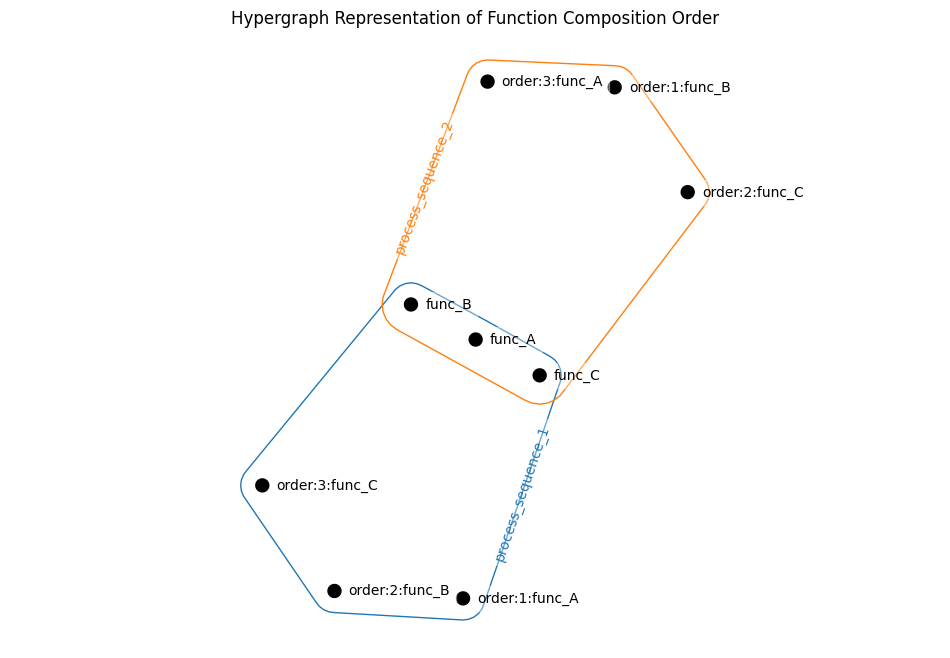

In [5]:
def create_ordered_hypergraph():
    edges = {
        # Three-function composition example
        'process_sequence_1': {
            'func_A', 'func_B', 'func_C',
            'order:1:func_A',  # func_A executes first
            'order:2:func_B',  # func_B executes second
            'order:3:func_C'   # func_C executes third
        },
        
        # Alternative ordering of same functions
        'process_sequence_2': {
            'func_A', 'func_B', 'func_C',
            'order:1:func_B',  # func_B executes first
            'order:2:func_C',  # func_C executes second
            'order:3:func_A'   # func_A executes third
        }
    }
    return hnx.Hypergraph(edges)

def get_execution_order(edge):
    """Extract the ordered sequence of functions from an edge"""
    order_nodes = [n for n in edge if n.startswith('order:')]
    # Sort by the numeric position (the middle element when split by ':')
    order_nodes.sort(key=lambda x: int(x.split(':')[1]))
    # Extract the function names (the last element when split by ':')
    return [n.split(':')[2] for n in order_nodes]

H_order = create_ordered_hypergraph()

plt.figure(figsize=(12, 8))
hnx.drawing.draw(H_order,
                with_node_labels=True,
                with_edge_labels=True)
plt.title("Hypergraph Representation of Function Composition Order")

### Analyzing Order Dependencies

We can analyze the hypergraph to detect order dependencies:


In [7]:
def analyze_function_compositions(H):
    """Analyze the execution order of function compositions in the hypergraph."""
    # Iterate through edge names in the hypergraph
    for edge_name in H.edges:
        edge = H.edges[edge_name]  # Get the edge by name
        ordered_sequence = get_execution_order(edge)
        print(f"Edge {edge_name} execution order: {' -> '.join(ordered_sequence)}")
        
        # Note: Commented out function composition since function_map is not defined
        # def compose_functions(sequence):
        #     return reduce(lambda f, g: lambda x: g(f(x)), 
        #                  [function_map[fname] for fname in sequence])

analyze_function_compositions(H_order)

Edge process_sequence_1 execution order: func_A -> func_B -> func_C
Edge process_sequence_2 execution order: func_B -> func_C -> func_A



## Key Benefits

This approach provides several advantages:
1. **Explicit Ordering**: Each function's position is clearly marked
2. **Scalable**: Works for any number of functions
3. **Flexible**: Can represent multiple orderings of the same functions
4. **Queryable**: Easy to extract and analyze the order programmatically
5. **Extensible**: Can be adapted for parallel, conditional, and grouped operations

The hypergraph structure is particularly well-suited for this because:
- Each edge can contain many nodes
- Nodes can participate in multiple edges
- The structure can represent both ordered and unordered relationships
- You can add metadata through node naming conventions
- The resulting structure can be visualized and analyzed using HyperNetX's tools

In [22]:
# Complex Function Composition Patterns in Hypergraphs

## Higher-Order Compositions with Mixed Ordering

def create_complex_hypergraph():
    edges = {
        # Subgroup 1: Ordered preprocessing steps
        'preprocess_sequence': {
            'normalize', 'filter_outliers', 'smooth',
            'order:1:normalize',
            'order:2:filter_outliers',
            'order:3:smooth',
            'group:preprocess'  # Group marker
        },
        
        # Subgroup 2: Commutative operations (order doesn't matter)
        'feature_ops': {
            'extract_mean', 'compute_variance', 'count_peaks',
            'group:features'  # Group marker
        },
        
        # Higher-order composition combining both subgroups
        'full_pipeline': {
            'preprocess_sequence',  # Reference to first subgroup
            'feature_ops',         # Reference to second subgroup
            'order:1:preprocess_sequence',  # Do preprocessing first
            'order:2:feature_ops'          # Then feature computation
        }
    }
    return hnx.Hypergraph(edges)

## Partially Shared Orderings

def create_shared_order_hypergraph():
    edges = {
        # Pipeline 1: A -> B -> C -> D
        'pipeline_1': {
            'func_A', 'func_B', 'func_C', 'func_D',
            'order:1:func_A',
            'order:2:func_B',
            'order:3:func_C',
            'order:4:func_D',
            'pipeline:1'
        },
        
        # Pipeline 2: A -> B -> E -> F
        # (shares initial A->B ordering with pipeline_1)
        'pipeline_2': {
            'func_A', 'func_B', 'func_E', 'func_F',
            'order:1:func_A',
            'order:2:func_B',
            'order:3:func_E',
            'order:4:func_F',
            'pipeline:2'
        }
    }
    return hnx.Hypergraph(edges)

## Conditional Branching with Shared Components

def create_conditional_hypergraph():
    edges = {
        # Base preprocessing (always runs)
        'base_process': {
            'load_data', 'validate',
            'order:1:load_data',
            'order:2:validate'
        },
        
        # Conditional branch for numerical data
        'numerical_branch': {
            'base_process',  # Include base processing
            'normalize_numerical', 'compute_stats',
            'condition:data_type:numerical',
            'order:3:normalize_numerical',
            'order:4:compute_stats'
        },
        
        # Conditional branch for categorical data
        'categorical_branch': {
            'base_process',  # Include base processing
            'encode_categorical', 'compute_frequencies',
            'condition:data_type:categorical',
            'order:3:encode_categorical',
            'order:4:compute_frequencies'
        }
    }
    return hnx.Hypergraph(edges)

def longest_common_subsequence(seq1, seq2):
    """Find the longest common subsequence between two sequences of functions"""
    m, n = len(seq1), len(seq2)
    # Create a matrix to store lengths of LCS for all subproblems
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Fill dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i-1] == seq2[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    
    # Backtrack to find the actual sequence
    lcs = []
    i, j = m, n
    while i > 0 and j > 0:
        if seq1[i-1] == seq2[j-1]:
            lcs.append(seq1[i-1])
            i -= 1
            j -= 1
        elif dp[i-1][j] > dp[i][j-1]:
            i -= 1
        else:
            j -= 1
            
    return list(reversed(lcs))  # Return the sequence in correct order

In [23]:
def analyze_composition_structure(H):
    """Analyze the structure of function compositions"""
    
    def get_groups(edge):
        """Extract group information from an edge"""
        return [n for n in edge if n.startswith('group:')]
    
    def get_conditions(edge):
        """Extract conditions from an edge"""
        return [n for n in edge if n.startswith('condition:')]
    
    # Iterate through edges in the hypergraph
    for edge_label in H.edges:  # Changed from H.edge_dict to H.edges
        print(f"\nAnalyzing edge: {edge_label}")
        edge = H.edges[edge_label]  # Get the edge contents
        
        # Get ordering if it exists
        ordered_sequence = get_execution_order(edge)
        if ordered_sequence:
            print(f"Execution order: {' -> '.join(ordered_sequence)}")
        
        # Get groups if they exist
        groups = get_groups(edge)
        if groups:
            print(f"Groups: {', '.join(groups)}")
        
        # Get conditions if they exist
        conditions = get_conditions(edge)
        if conditions:
            print(f"Conditions: {', '.join(conditions)}")

def find_shared_orderings(H):
    """Find functions that share ordering constraints across edges"""
    from itertools import combinations
    edge_orders = {}
    
    # Changed to use edges instead of edge_dict
    for edge_label in H.edges:
        ordered_sequence = get_execution_order(H.edges[edge_label])
        if ordered_sequence:
            edge_orders[edge_label] = ordered_sequence
    
    # Find shared subsequences
    shared = {}
    for (label1, seq1), (label2, seq2) in combinations(edge_orders.items(), 2):
        common = longest_common_subsequence(seq1, seq2)
        if len(common) >= 2:  # At least 2 functions in common
            shared[(label1, label2)] = common
    
    return shared

In [24]:
# Create and analyze a complex hypergraph
H = create_complex_hypergraph()
analyze_composition_structure(H)

# Find shared orderings
shared_orders = find_shared_orderings(H)
for (edge1, edge2), common in shared_orders.items():
    print(f"\nShared ordering between {edge1} and {edge2}:")
    print(f"Common sequence: {' -> '.join(common)}")


Analyzing edge: feature_ops
Groups: group:features

Analyzing edge: full_pipeline
Execution order: preprocess_sequence -> feature_ops

Analyzing edge: preprocess_sequence
Execution order: normalize -> filter_outliers -> smooth
Groups: group:preprocess


/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.grou

In [32]:
def visualize_shared_orderings(H, shared_orders):
    """
    Visualize the hypergraph with highlighted shared orderings.
    """
    plt.figure(figsize=(15, 10))
    
    # Draw the basic hypergraph
    hnx.drawing.draw(H,
                    with_node_labels=True,
                    with_edge_labels=True)
    
    # Add legend for shared sequences
    legend_elements = []
    for (edge1, edge2), common in shared_orders.items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor='lightblue', markersize=10,
                                        label=f'Shared: {edge1} ↔ {edge2}\n({" -> ".join(common)})'))
    
    # Add legend for node types
    legend_elements.extend([
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue',
                  markersize=15, label='Function'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgray',
                  markersize=10, label='Order'),
        plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='lightgreen',
                  markersize=12, label='Group'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='lightyellow',
                  markersize=12, label='Condition')
    ])
    
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Hypergraph with Shared Orderings")
    plt.tight_layout()
    return plt

/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.grou

<module 'matplotlib.pyplot' from '/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/matplotlib/pyplot.py'>

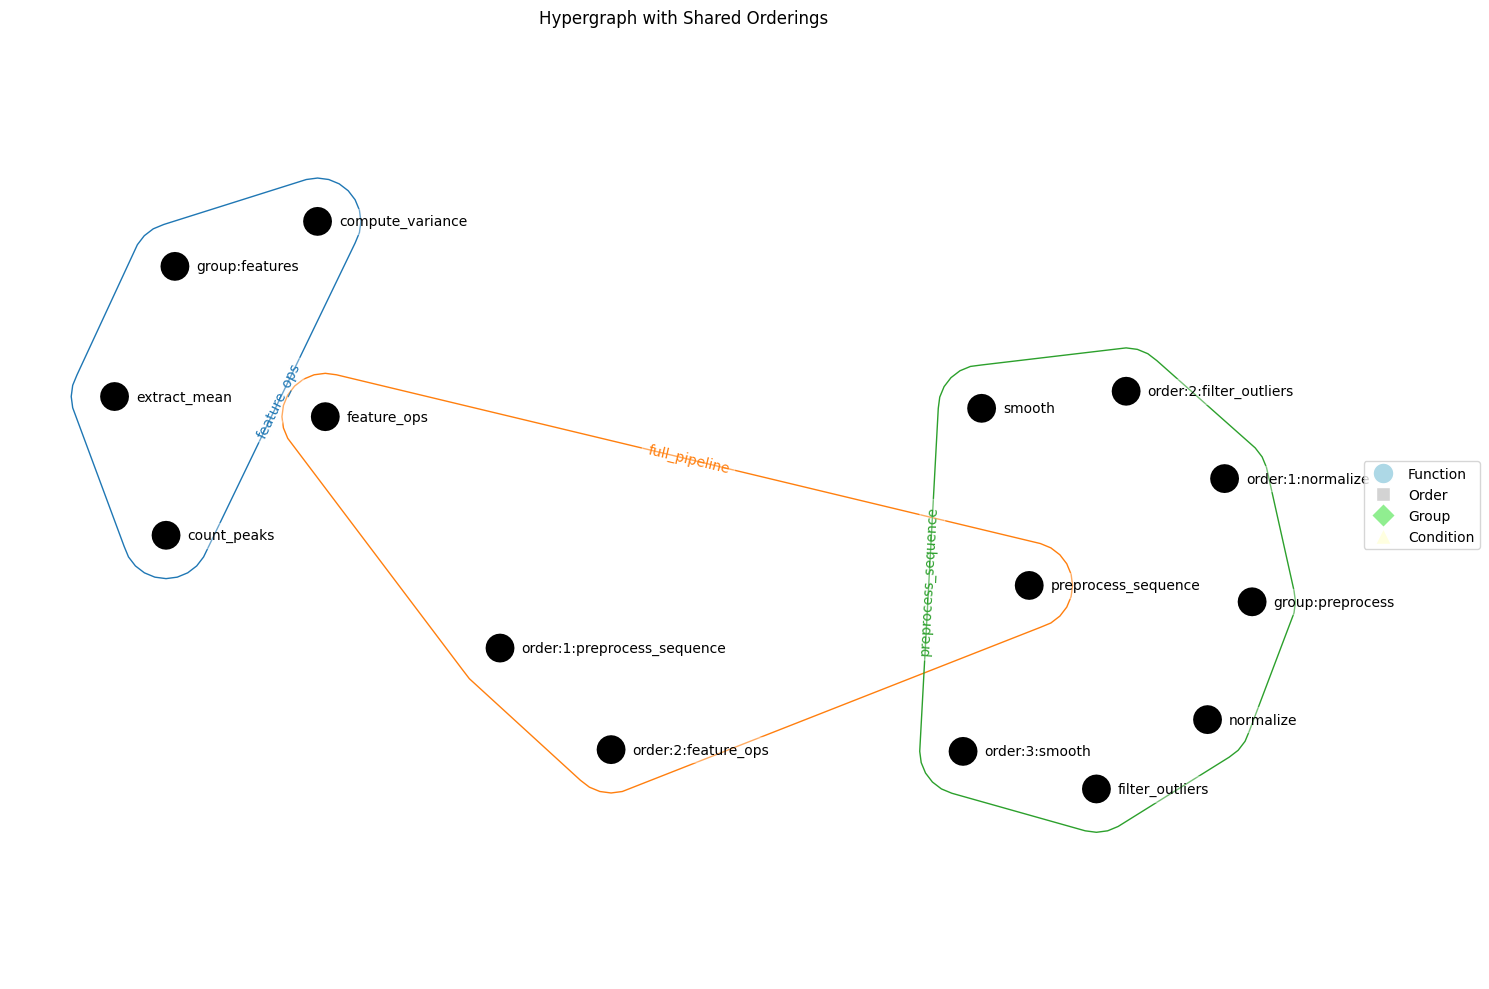

In [33]:
visualize_shared_orderings(H, shared_orders)